
## Sentiment prediction from Tweet text

In [30]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter

from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn import cluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import scipy 
import scipy.stats as stats

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

In [32]:
# Input and clean up data by removing columns not useful for analysis
tweets = pd.read_csv('Tweets.csv')
del tweets['tweet_id']
del tweets['retweet_count']
del tweets['tweet_coord']
del tweets['name']
del tweets['airline_sentiment_gold']
del tweets['tweet_created']
del tweets['user_timezone']
del tweets['negativereason_confidence']
del tweets['airline_sentiment_confidence']
del tweets['negativereason_gold']
tweets.head() 

,airline_sentiment,negativereason,airline,text,tweet_location
0,neutral,NaN,Virgin America,@VirginAmerica What @dhepburn said.,NaN
1,positive,NaN,Virgin America,@VirginAmerica plus you've added commercials t...,NaN
2,neutral,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...,Lets Play
3,negative,Bad Flight,Virgin America,@VirginAmerica it's really aggressive to blast...,NaN
4,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing...,NaN


In [33]:
# scanning data
print ("Airlines: ", tweets['airline'].dropna().unique())
print (" ")
print ("Sentiment: ", tweets['airline_sentiment'].dropna().unique())
print (" ")
print ("Negative comments: ", tweets['negativereason'].dropna().unique())
print (" ")
print ("Locations: ", tweets['tweet_location'].dropna().unique())

Airlines:  ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']
 
Sentiment:  ['neutral' 'positive' 'negative']
 
Negative comments:  ['Bad Flight' "Can't Tell" 'Late Flight' 'Customer Service Issue'
 'Flight Booking Problems' 'Lost Luggage' 'Flight Attendant Complaints'
 'Cancelled Flight' 'Damaged Luggage' 'longlines']
 
Locations:  ['Lets Play' 'San Francisco CA' 'Los Angeles' ..., 'Columbus, OH, USA'
 'Milwaukee County, Wisconsin' 'Nigeria,lagos']


In [34]:
# function to clean up Twitter text
def clean_tweet(str):

    str = str.lower() 
    tokens = nltk.word_tokenize(str)                            # tokenize
    tokens = [i for i in tokens if i not in string.punctuation] # remove punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [i for i in tokens if i not in stop_words]  # remove stop words
    tokens = [i for i in tokens if   not i.isdigit()]    # remove numbers
    tokens = [i for i in tokens if i.isalnum()]          # remove alpha numeric characters

    tokens = list(set(tokens)) # Remove duplicates.
    #print("Length: ", len(tokens))
    
    clean_text = ' '.join(token for token in tokens) # string output, not list.
    
    return clean_text

In [35]:
# Add clean tweets field.
#print (tweets_train['text'][0])
#print (clean_tweet(tweets_train['text'][0]))
tweets['clean_tweet']= tweets['text'].apply(lambda s: clean_tweet(s))
tweets['sentiment'] =  tweets['airline_sentiment'].apply(lambda x: -1 if x=='negative' else 1)
tweets.head()

,airline_sentiment,negativereason,airline,text,tweet_location,clean_tweet,sentiment
0,neutral,NaN,Virgin America,@VirginAmerica What @dhepburn said.,NaN,dhepburn virginamerica said,1
1,positive,NaN,Virgin America,@VirginAmerica plus you've added commercials t...,NaN,experience virginamerica plus commercials adde...,1
2,neutral,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...,Lets Play,need another take must today virginamerica mea...,1
3,negative,Bad Flight,Virgin America,@VirginAmerica it's really aggressive to blast...,NaN,faces amp obnoxious aggressive blast recourse ...,-1
4,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing...,NaN,virginamerica bad really thing big,-1


In [36]:
# Predictive Modeling

tweets_train, tweets_test = train_test_split(tweets, test_size=0.10, random_state=42)
print ("Training: ", tweets_train.shape)
print ("Test: ", tweets_test.shape)

# train and test clean tweets for training sentiment on words
train_clean_text = []
for t in tweets_train['clean_tweet']:
    train_clean_text.append(t)
    
test_clean_text = []
for t in tweets_test['clean_tweet']:
    test_clean_text.append(t)


Training:  (13176, 7)
Test:  (1464, 7)


In [37]:
# Predict Sentiment of the tweet (Positive = 1, Negative/Neutral = 0) 

# Reference: http://scikit-learn.org/stable/modules/feature_extraction.html
# Build training and test features matrix from relevant clean tweet text
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features = v.fit_transform(train_clean_text)
test_features  = v.transform(test_clean_text)

X = train_features
y = tweets_train['sentiment']

In [38]:
# Try different classfier for prediction and compare accuracies
# For SVC, experimented with different value of C and picked 0.1.
Classifiers = [svm.SVC(C=0.1), tree.DecisionTreeClassifier(),RandomForestClassifier(n_estimators=100), KNeighborsClassifier()]
names = []
accuracies = []

In [41]:

for C in Classifiers:
    print("Classifier Method: ", C.__class__.__name__)
    names.append(C.__class__.__name__)
    clf = C.fit(X,y)
    print("Training data accuracy: ", clf.score(X,y))
    print("Test data cross validation accuracy:")
    scores = cross_val_score(clf, test_features, tweets_test['sentiment'], cv=5)
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std())) 
    accuracies.append(scores.mean())
    print(" ")

Classifier Method:  SVC
Training data accuracy:  0.626442015786
Test data cross validation accuracy:
[ 0.63139932  0.63139932  0.63139932  0.63139932  0.63013699]
Accuracy: 0.63 (+/- 0.00)
 
Classifier Method:  DecisionTreeClassifier
Training data accuracy:  0.997874924104
Test data cross validation accuracy:
[ 0.66552901  0.64846416  0.65187713  0.68259386  0.69520548]
Accuracy: 0.67 (+/- 0.02)
 
Classifier Method:  RandomForestClassifier
Training data accuracy:  0.997874924104
Test data cross validation accuracy:
[ 0.73720137  0.75767918  0.75767918  0.74744027  0.76712329]
Accuracy: 0.75 (+/- 0.01)
 
Classifier Method:  KNeighborsClassifier
Training data accuracy:  0.693989071038
Test data cross validation accuracy:
[ 0.47440273  0.43686007  0.44027304  0.3890785   0.45890411]
Accuracy: 0.44 (+/- 0.03)
 


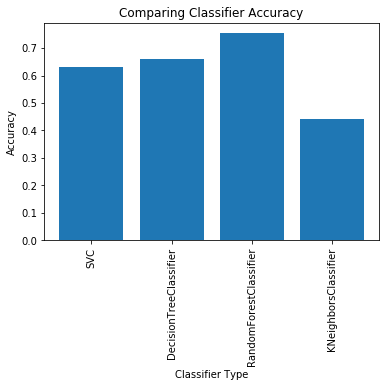

In [40]:
%matplotlib inline
index = [1,2,3,4]
plt.bar(index,accuracies)
plt.xticks(index, names,rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Classifier Type')
plt.title('Comparing Classifier Accuracy')

## References:

(1) Dataset: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

(2) www.nltk.org

(3) http://scikit-learn.org/stable/modules/feature_extraction.html

(4) https://de.dariah.eu/tatom/working_with_text.html